In [1]:
import pickle
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston
%matplotlib inline
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from collections import OrderedDict
import gc
from sklearn import datasets, linear_model,preprocessing
from IPython.display import display, HTML
import time
import nltk.corpus
from nltk.stem.snowball import SnowballStemmer

def RMSE(y_true,y_pred):
    mse = np.sqrt(mean_squared_error(y_true, y_pred))
    print 'MSE: %2.3f' % mse
    return mse

#take 1 CSV, then split it to 3..
class FeatureEngineering:

    def __init__(self, ValidationStart, ValidationEnd, trainHdfPath, trainHdfFile, testHdfPath1, testHdfPath2, testHdfFile, 
                 testTypes, trainTypes, trainCsvPath, testCsvPath, maxLag=0):
        self.ValidationStart = ValidationStart
        self.ValidationEnd = ValidationEnd
        self.maxLag = maxLag
        self.trainHdfPath = trainHdfPath
        self.trainHdfFile = trainHdfFile
        self.testHdfPath1 = testHdfPath1
        self.testHdfPath2 = testHdfPath2
        self.testHdfFile = testHdfFile
        self.testTypes = testTypes
        self.trainTypes = trainTypes
        self.trainCsvPath = trainCsvPath
        self.testCsvPath = testCsvPath
        
    @staticmethod
    def __printDataFrameBasics__(data):
        display(data.head(2))
        #print data.dtypes
        gc.collect()
        print(data.info(memory_usage=True))
        
    @staticmethod    
    def changeIndexTypeToLowerMemory(data):
        ##########
        #This is very critical, i accept max number is 2^32. Also, if don't do that, memory gets so much higher..
        ##########
        #data.reset_index(inplace=True)
        #data.drop("index",axis=1, inplace=True)
        #data.index = data.index.astype('uint32')
        gc.collect()
        
    def ReadHdf(self, trainOrTestOrBoth):
        '''Reads and holds Df in object memory'''            
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train = pd.read_hdf(self.trainHdfPath,self.trainHdfFile)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.train)
            FeatureEngineering.__printDataFrameBasics__(self.train)
            
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            self.test1 = pd.read_hdf(self.testHdfPath1,self.testHdfFile)
            self.test2 = pd.read_hdf(self.testHdfPath2,self.testHdfFile)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test1)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test2)
            FeatureEngineering.__printDataFrameBasics__(self.test1)
            FeatureEngineering.__printDataFrameBasics__(self.test2)
        
    def ReadCsv(self, trainOrTestOrBoth):
        '''Reads and holds Df in memory'''
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth == 'both':
            self.train = pd.read_csv(self.trainCsvPath, usecols=self.trainTypes.keys(), dtype=self.trainTypes)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.train)
            FeatureEngineering.__printDataFrameBasics__(self.train)
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            tempTest = pd.read_csv(self.testCsvPath, usecols=self.testTypes.keys(), dtype=self.testTypes)
            self.test1 = tempTest.loc[tempTest.Semana.values == self.ValidationStart]
            self.test2 = tempTest.loc[tempTest.Semana.values == self.ValidationEnd]
            del tempTest
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test1)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test2)
            FeatureEngineering.__printDataFrameBasics__(self.test1)
            FeatureEngineering.__printDataFrameBasics__(self.test2)
            
    @staticmethod
    def ConvertCsvToHdf(csvPath, HdfPath, HdfName, ColumnTypeDict ):
        tempDf = pd.read_csv(csvPath, usecols=ColumnTypeDict.keys(), dtype=ColumnTypeDict,index=False)
        tempDf.to_hdf(HdfPath, HdfName, format='t')
        del tempDf
        gc.collect()
        print "ConvertCsvToHdf is done.."

    def Preprocess(self, trainOrTestOrBoth, columnFunctionTypeList):
        '''columnFunctionTypeList = [ ['C1',Func1,Type], ['C2',Func2,Type],..    ]'''
        for column, func, localType in columnFunctionTypeList:
            if trainOrTestOrBoth == 'train' or trainOrTestOrBoth =='both':
                self.train.loc[:,column] =  np.apply_along_axis(func,0,FE.train[column].values).astype(localType)
                #np.apply_along_axis(lambda x: x+1,0,FE.train["Semana"]).astype("int32")
            if trainOrTestOrBoth == 'test' or trainOrTestOrBoth == 'both':
                self.test1.loc[:,column] =  np.apply_along_axis(func,0,FE.test1[column].values).astype(localType)
                self.test2.loc[:,column] =  np.apply_along_axis(func,0,FE.test2[column].values).astype(localType)
        gc.collect()
        
    def SaveDataFrameToHdf(self,trainOrTestOrBoth):
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train.to_hdf(self.trainHdfPath, self.trainHdfFile, format='t', index="False")
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            self.test1.to_hdf(self.testHdfPath1, self.testHdfFile, format='t', index="False")
            self.test2.to_hdf(self.testHdfPath2, self.testHdfFile, format='t', index="False")
        
    def AddDemandaGeneralMean(self,trainOrTestOrBoth): 
        #self.train.loc[:,"DemandaGeneralMean"] = self.train["Demanda_uni_equil"].loc[
         #   self.train.loc[:,'Semana'] < 10].mean().astype("float32")
            
        meanOfDemanda = self.train["Demanda_uni_equil"].values.mean().astype("float32")
        
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train.loc[:,"DemandaGeneralMean"] = meanOfDemanda
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            self.test1.loc[:,"DemandaGeneralMean"] = meanOfDemanda
            self.test2.loc[:,"DemandaGeneralMean"] = meanOfDemanda
        
        #self.train.loc[:,"DemandaGeneralMean"] = self.train["Demanda_uni_equil"].values[
        #(self.train.loc[:,'Semana'].values < self.ValidationStart).values].mean().astype("float32")
        gc.collect()
        
    '''ConfigElements(0,[ ("A",["Semana","Agencia_ID"],["count","count"]),'''
    def AddConfigurableFeaturesToTrain(self, config):
        if config.lag > self.maxLag:
            self.maxLag = config.lag
        
        tempData = self.train[self.train['Semana'].values <= (self.ValidationEnd - config.lag)]
        #display(tempData)
        if(config.lag != 0):
            tempData.loc[:,'Semana'] = tempData['Semana'].values + config.lag
        #display(tempData)
        
        #Means iterative.. eliminate as long as np.nan exists..If there is already one, don't create, use the existing
        if config.targetVariable != "" and  config.targetVariable not in self.train.columns:
            self.train.loc[:,config.targetVariable] = np.nan
            self.test1.loc[:,config.targetVariable] = np.nan
            
            if config.lag != 1:
                self.test2.loc[:,config.targetVariable] = np.nan
        
        for name,groups,aggregate in config.nameAndGroups:
            if name not in self.train.columns:
                print "{} is not in columns..".format(name)            
                
                groupedDataframe = tempData[groups+['Demanda_uni_equil']].copy().groupby(groups).agg(aggregate[0])
                gc.collect()
                #groupedDataframe.columns = groupedDataframe.columns.droplevel(0)
                groupedDataframe.columns = [name]
                
                #This is means of the counts of the semana-columns tuples!..!!!
                #If no lag and mean, mean of the columns without semana!!..
                #If there is lag and count, count of the columns x weeks before
                #If there is lag and mean, mean of the columns x weeks before
                #if(config.lag == 0 and aggregate == "count"):
                if(len(aggregate)>1):
                    groupedDataframe.reset_index(inplace=True)
                    groupedDataframe.drop("Semana",axis=1, inplace=True)
                    groups = groups[1:]
                    groupedDataframe = groupedDataframe.groupby(groups).agg(aggregate[1])
                    groupedDataframe.columns = [name]
                    gc.collect()
                
                display(groupedDataframe)
                self.train = self.train.merge( groupedDataframe, left_on=groups,
                    right_index=True, how='left', sort=False,copy=False)
                gc.collect()
                self.test1 = self.test1.merge( groupedDataframe, left_on=groups,
                    right_index=True, how='left', sort=False,copy=False)
                gc.collect()
                if config.lag != 1:
                    self.test2 = self.test2.merge( groupedDataframe, left_on=groups,
                        right_index=True, how='left', sort=False,copy=False)
                
                del groupedDataframe
                gc.collect()
            else:
                print "{} is in columns..".format(name)
            
            display(self.train)
            display(self.test1)
            display(self.test2)
            
            #Means iterative..!!!!!
            if config.targetVariable != "":
                self.train.loc[pd.isnull(self.train[config.targetVariable].values), 
                    config.targetVariable] = self.train.loc[pd.isnull(self.train[config.targetVariable].values)
                    , name].values
                self.test1.loc[pd.isnull(self.test1[config.targetVariable].values), 
                    config.targetVariable] = self.test1.loc[pd.isnull(self.test1[config.targetVariable].values),
                    name].values
                if config.lag != 1:
                    self.test2.loc[pd.isnull(self.test2[config.targetVariable].values), 
                        config.targetVariable] = self.test2.loc[pd.isnull(self.test2[config.targetVariable].values)
                        , name].values
                    
                count = self.test1[config.targetVariable].isnull().sum()
                print "Count of missing numbers after {} in validation part 1 in column {} is {}".format(name, 
                    config.targetVariable,str(count))
                if config.lag != 1:
                    count = self.test2.loc[:,config.targetVariable].isnull().sum()
                    print "Count of missing numbers after {} in validation part 2 in column {} is {}".format(name, 
                        config.targetVariable,str(count))
                
                
                #display(self.train)
                #If column is already in Dataframe and we want to fill target variable, this deletes columns!!!
                if(config.deleteColumns):
                    self.train.drop(name, axis=1, inplace=True)
                    self.test1.drop(name, axis=1, inplace=True)
                    if config.lag != 1:
                        self.test2.drop(name, axis=1, inplace=True)
                gc.collect()
                #Only in tesst
                #if count == 0:
                 #   break
        del tempData
        display(self.train)   
        display(self.test1)   
        display(self.test2)
        gc.collect()
        return 
    
    def DeleteLaggedWeeksFromTrain(self):
        self.train = self.train[self.train['Semana'].values >= (3 + self.maxLag)]
        gc.collect()
        display(self.train.head(2))
        
    def ReadFirstNRowsOfACsv(self, nrows, trainOrTestOrBoth) :
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train = pd.read_csv(self.trainCsvPath, usecols=self.trainTypes.keys(), dtype=self.trainTypes, nrows = nrows)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.train)
            FeatureEngineering.__printDataFrameBasics__(self.train)
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            tempTest = pd.read_csv(self.testCsvPath, usecols=self.testTypes.keys(), dtype=self.testTypes, nrows = nrows*2)
            self.test1 = tempTest.loc[tempTest.Semana == self.ValidationStart]
            self.test2 = tempTest.loc[tempTest.Semana == self.ValidationEnd]
            del tempTest
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test1)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test2)
            FeatureEngineering.__printDataFrameBasics__(self.test1)
            FeatureEngineering.__printDataFrameBasics__(self.test2)
    
    #Use when concatanating train and validation before predict test for example..
    def AppendTestToTrain(self,deleteTest = True):
        self.train = self.train.append(self.test1,ignore_index=True)
        gc.collect()
        if(deleteTest):
            del self.test1
            gc.collect()
        try:
            self.train = self.train.append(self.test2,ignore_index=True)
            gc.collect()
            if(deleteTest):
                del self.test2
                gc.collect()
        except:
            pass
        #BAD PERFORMANCE!!
    #Split train data to train and test1 and test2 (validation)
    #def SplitTrainToTestUsingValidationStart(self):
     #   boolCondition = self.train.Semana == self.ValidationStart
      #  self.test1 = self.train.loc[boolCondition]
       # self.train.drop((self.train.loc[boolCondition].index), axis=0,inplace=True)
        
       # boolCondition = self.train.Semana == self.ValidationEnd
       # self.test2 = self.train.loc[boolCondition]
       # self.train.drop((self.train.loc[boolCondition].index), axis=0,inplace=True)
      #  del boolCondition
      #  gc.collect()
    
    #Reaches 3x memory from train, because of test1, test2 and train itself at the end.. GC fixed in the end..
    def SplitTrainToTestUsingValidationStart(self):
        boolCondition = self.train.Semana.values == self.ValidationStart
        self.test1 = self.train[boolCondition]
        boolCondition = self.train.Semana.values == self.ValidationEnd
        self.test2 = self.train[boolCondition]
        FE.train = FE.train[ FE.train.Semana.values < FE.ValidationStart ]
        del boolCondition
        gc.collect()
        
    def XgboostPredictAndSee(self, Test1OrTest2):
        self.train_y = self.train["Demanda_uni_equil"].copy()
        self.train.drop("Demanda_uni_equil",axis=1, inplace=True)
        

In [2]:
parameterDict =       {"ValidationStart":8, 
 "ValidationEnd":9,
   "maxLag":3,
    "trainHdfPath":'../../input/train_wz.h5',
    "trainHdfFile":"train",
    "testHdfPath1":"../../input/test1_wz.h5",
    "testHdfPath2":"../../input/test2_wz.h5",
    "testHdfFile":"test", 
    "trainTypes" : {'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,'Ruta_SAK':np.uint16, 
        'Cliente_ID':np.uint32, 'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint16, 'Venta_hoy':np.float32,
                    'Dev_uni_proxima': np.uint32, 'Dev_proxima':np.float32,'Demanda_uni_equil':np.uint32}, 
    "testTypes" : {'id':np.uint32,'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,'Ruta_SAK':np.uint16,
        'Cliente_ID':np.uint32, 'Producto_ID':np.uint16},
    "trainCsvPath":'../../input/train.csv'   ,
    "testCsvPath":'../../input/test.csv'}

FE = FeatureEngineering(**parameterDict)
print FE.__dict__

{'trainCsvPath': '../../input/train.csv', 'maxLag': 3, 'testTypes': {'Cliente_ID': <type 'numpy.uint32'>, 'Ruta_SAK': <type 'numpy.uint16'>, 'Canal_ID': <type 'numpy.uint8'>, 'Producto_ID': <type 'numpy.uint16'>, 'Agencia_ID': <type 'numpy.uint16'>, 'Semana': <type 'numpy.uint8'>, 'id': <type 'numpy.uint32'>}, 'testHdfFile': 'test', 'trainTypes': {'Dev_proxima': <type 'numpy.float32'>, 'Venta_uni_hoy': <type 'numpy.uint16'>, 'Cliente_ID': <type 'numpy.uint32'>, 'Demanda_uni_equil': <type 'numpy.uint32'>, 'Ruta_SAK': <type 'numpy.uint16'>, 'Canal_ID': <type 'numpy.uint8'>, 'Venta_hoy': <type 'numpy.float32'>, 'Producto_ID': <type 'numpy.uint16'>, 'Agencia_ID': <type 'numpy.uint16'>, 'Dev_uni_proxima': <type 'numpy.uint32'>, 'Semana': <type 'numpy.uint8'>}, 'testHdfPath1': '../../input/test1_wz.h5', 'ValidationEnd': 9, 'testHdfPath2': '../../input/test2_wz.h5', 'testCsvPath': '../../input/test.csv', 'ValidationStart': 8, 'trainHdfFile': 'train', 'trainHdfPath': '../../input/train_wz.h5'}

In [3]:
FE.ReadHdf('both')

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,3,1110,7,3301,15766,1212,3,25.139999,0,0.0,...,4207,0.0,114,0.0,7091.0,877686,0.008079,13236.0,1490894,0.008878
1,3,1110,7,3301,15766,1216,4,33.520000,0,0.0,...,4207,0.0,114,0.0,5426.0,759241,0.007147,9532.0,1247361,0.007642


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53364883 entries, 0 to 53364882
Data columns (total 46 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,8,1110,7,3301,15766,1212,4,33.520000,0,0.0,...,4207,0.0,114.0,0.0,7091.0,877686.0,0.008079,13236.0,1490894.0,0.008878
1,8,1110,7,3301,15766,1216,5,41.900002,0,0.0,...,4207,0.0,114.0,0.0,5426.0,759241.0,0.007147,9532.0,1247361.0,0.007642


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10406868 entries, 0 to 10406867
Data columns (total 44 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,9,1110,7,3301,15766,1212,1,8.38,0,0.0,...,4207,0.0,114.0,0.0,7091.0,877686.0,0.008079,13236.0,1490894.0,0.008878
1,9,1110,7,3301,15766,1238,2,19.66,0,0.0,...,4207,0.0,114.0,0.0,6921.0,879701.0,0.007867,7906.0,1002026.0,0.007890


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10408713 entries, 0 to 10408712
Data columns (total 43 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

In [4]:
FE.DeleteLaggedWeeksFromTrain()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
32790197,6,1110,7,3301,15766,1216,1,8.38,0,0.0,...,4207,0.0,114,0.0,5426.0,759241,0.007147,9532.0,1247361,0.007642
32790198,6,1110,7,3301,15766,1238,2,19.66,0,0.0,...,4207,0.0,114,0.0,6921.0,879701,0.007867,7906.0,1002026,0.007890


In [5]:

FE.train[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Demanda_uni_equil_original',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate'
         ]]=FE.train[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Demanda_uni_equil_original',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate']].astype('float32')
gc.collect()
FE.train[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count'
         ]]=FE.train[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count']].astype('uint32')

gc.collect()

FE.test1[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate'
         ]]=FE.test1[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate']].astype('float32')
gc.collect()
FE.test1[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count'
         ]]=FE.test1[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count']].astype('uint32')

gc.collect()

FE.test2[['Lag0', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate'
         ]]=FE.test2[['Lag0', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate']].astype('float32')
gc.collect()
FE.test2[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count'
         ]]=FE.test2[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count']].astype('uint32')

gc.collect()

7

## Trial 8: Reverting back to basics.

In [6]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

In [7]:
X_train = FE.train[test1columns]
X_test = FE.test1[test1columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]

In [8]:
gc.collect()

0

[0]	validation_0-rmse:1.32238	validation_1-rmse:1.32189
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[5]	validation_0-rmse:1.06807	validation_1-rmse:1.07344
[10]	validation_0-rmse:0.869186	validation_1-rmse:0.884838
[15]	validation_0-rmse:0.721868	validation_1-rmse:0.748338
[20]	validation_0-rmse:0.615636	validation_1-rmse:0.652505
[25]	validation_0-rmse:0.537144	validation_1-rmse:0.585026
[30]	validation_0-rmse:0.45899	validation_1-rmse:0.536272
[35]	validation_0-rmse:0.416984	validation_1-rmse:0.508788
[40]	validation_0-rmse:0.381315	validation_1-rmse:0.490716
[45]	validation_0-rmse:0.353457	validation_1-rmse:0.47964
[50]	validation_0-rmse:0.328164	validation_1-rmse:0.473572
[55]	validation_0-rmse:0.307941	validation_1-rmse:0.470604
[60]	validation_0-rmse:0.294136	validation_1-rmse:0.469888
[65]	validation_0-rmse:0.284041	validation_1-rmse:0.470309
[70]	validation_0-rmse:

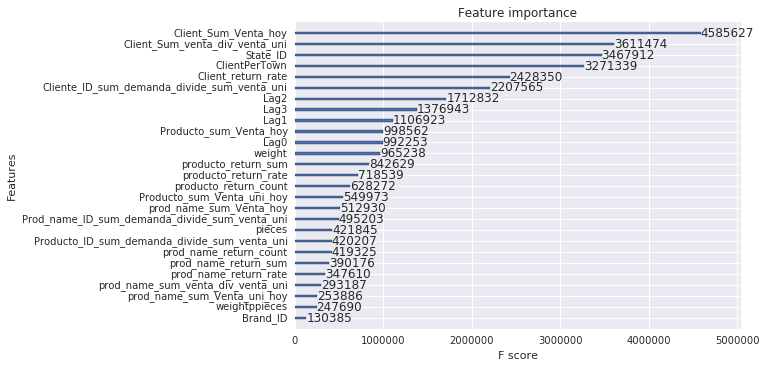

In [9]:
defaultParams = {"max_depth":25, "subsample":1., "min_child_weight":7, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.05}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=5, early_stopping_rounds = 15)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

In [10]:
gc.collect()
print("Pickling sklearn API models 1")
# must open in binary format to pickle
pickle.dump(xgb_model1, open("../../input/LastShot.pkl", "wb"))

Pickling sklearn API models 1


In [11]:
gc.collect()

9

In [12]:
X_train = FE.train[test2columns]
X_test = FE.test2[test2columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]
gc.collect()

0

[0]	validation_0-rmse:1.32238	validation_1-rmse:1.31632
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[5]	validation_0-rmse:1.06061	validation_1-rmse:1.06562
[10]	validation_0-rmse:0.860739	validation_1-rmse:0.880606
[15]	validation_0-rmse:0.704249	validation_1-rmse:0.743876
[20]	validation_0-rmse:0.584588	validation_1-rmse:0.64848
[25]	validation_0-rmse:0.495407	validation_1-rmse:0.585357
[30]	validation_0-rmse:0.43176	validation_1-rmse:0.545395
[35]	validation_0-rmse:0.393219	validation_1-rmse:0.520618
[40]	validation_0-rmse:0.364948	validation_1-rmse:0.505844
[45]	validation_0-rmse:0.343353	validation_1-rmse:0.496654
[50]	validation_0-rmse:0.319178	validation_1-rmse:0.492189
[55]	validation_0-rmse:0.300455	validation_1-rmse:0.490991
[60]	validation_0-rmse:0.286559	validation_1-rmse:0.490435
[65]	validation_0-rmse:0.278626	validation_1-rmse:0.490853
[70]	validation_0-rmse:

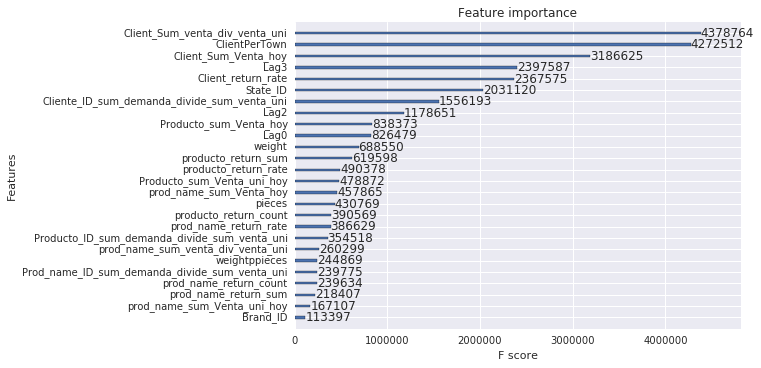

In [13]:
defaultParams = {"max_depth":25, "subsample":1., "min_child_weight":7, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.05}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=5, early_stopping_rounds = 15)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

In [14]:
gc.collect()

11281

In [15]:

print("Pickling sklearn API models 2")
# must open in binary format to pickle
pickle.dump(xgb_model2, open("../../input/LastShot2.pkl", "wb"))

Pickling sklearn API models 2


In [16]:
gc.collect()

9

{'trainCsvPath': '../../input/train.csv', 'maxLag': 3, 'testTypes': {'Cliente_ID': <type 'numpy.uint32'>, 'Ruta_SAK': <type 'numpy.uint16'>, 'Canal_ID': <type 'numpy.uint8'>, 'Producto_ID': <type 'numpy.uint16'>, 'Agencia_ID': <type 'numpy.uint16'>, 'Semana': <type 'numpy.uint8'>, 'id': <type 'numpy.uint32'>}, 'testHdfFile': 'test', 'trainTypes': {'Dev_proxima': <type 'numpy.float32'>, 'Venta_uni_hoy': <type 'numpy.uint16'>, 'Cliente_ID': <type 'numpy.uint32'>, 'Demanda_uni_equil': <type 'numpy.uint32'>, 'Ruta_SAK': <type 'numpy.uint16'>, 'Canal_ID': <type 'numpy.uint8'>, 'Venta_hoy': <type 'numpy.float32'>, 'Producto_ID': <type 'numpy.uint16'>, 'Agencia_ID': <type 'numpy.uint16'>, 'Dev_uni_proxima': <type 'numpy.uint32'>, 'Semana': <type 'numpy.uint8'>}, 'testHdfPath1': '../../input/test1_full_wz2.h5', 'ValidationEnd': 11, 'testHdfPath2': '../../input/test2_full_wz2.h5', 'testCsvPath': '../../input/test.csv', 'ValidationStart': 10, 'trainHdfFile': 'train', 'trainHdfPath': '../../input

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,3,1110,7,3301,15766,1212,3,25.139999,0,0.0,...,4408,0.0,160,0.0,11316.0,1196000,0.009462,20746.0,2029841,0.010221
1,3,1110,7,3301,15766,1216,4,33.520000,0,0.0,...,4408,0.0,160,0.0,8087.0,1024504,0.007894,14235.0,1689455,0.008426


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74180464 entries, 0 to 74180463
Data columns (total 46 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Town_ID,State_ID,weight,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,2,10,2045,1,2831,4549769,32940,2163,14,110,...,4180,0.0,22.0,0.0,1004.0,250443.0,0.004009,1205.0,301469.0,0.003997
1,7,10,1612,1,2837,4414012,35305,2352,30,75,...,4139,0.0,9.0,0.0,1709.0,537709.0,0.003178,6286.0,1455315.0,0.004319


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3538385 entries, 0 to 3538384
Data columns (total 40 columns):
id                                               uint32
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                     uint16
Brand_ID                                         uint8
Lag0                                             float64
Lag1                                             float64
Lag2                                             f

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Town_ID,State_ID,weight,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,0,11,4037,1,2209,4639078,35305,2499,28,75,...,5795,1.0,16.0,0.0625,1709.0,537709.0,0.003178,6286.0,1455315.0,0.004319
1,1,11,2237,1,1226,4705135,1238,2402,4,140,...,7596,0.0,33.0,0.0000,11260.0,1191873.0,0.009447,12904.0,1363704.0,0.009462


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3460866 entries, 0 to 3460865
Data columns (total 39 columns):
id                                               uint32
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                     uint16
Brand_ID                                         uint8
Lag0                                             float64
Lag2                                             float64
Lag3                                             f

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
32790197,6,1110,7,3301,15766,1216,1,8.38,0,0.0,...,4408,0.0,160,0.0,8087.0,1024504,0.007894,14235.0,1689455,0.008426
32790198,6,1110,7,3301,15766,1238,2,19.66,0,0.0,...,4408,0.0,160,0.0,11260.0,1191873,0.009447,12904.0,1363704,0.009462


(41390267, 27)
(3538385, 27)
(41390267,)
[0]	validation_0-rmse:1.32006
[5]	validation_0-rmse:1.06776
[10]	validation_0-rmse:0.87159
[15]	validation_0-rmse:0.726851
[20]	validation_0-rmse:0.623423
[25]	validation_0-rmse:0.548118
[30]	validation_0-rmse:0.475222
[35]	validation_0-rmse:0.436574
[40]	validation_0-rmse:0.405668
[45]	validation_0-rmse:0.383127
[50]	validation_0-rmse:0.362643
[55]	validation_0-rmse:0.347006
trainResult:  0.339991369067
Best Iteration:  59
Best Score:  0.469628
Axes(0.125,0.125;0.775x0.775)
[0]	validation_0-rmse:1.32006
[5]	validation_0-rmse:1.06069
[10]	validation_0-rmse:0.863383
[15]	validation_0-rmse:0.710346
[20]	validation_0-rmse:0.594376
[25]	validation_0-rmse:0.509257
[30]	validation_0-rmse:0.449995
[35]	validation_0-rmse:0.414798
[40]	validation_0-rmse:0.389495
[45]	validation_0-rmse:0.371125
[50]	validation_0-rmse:0.351479
[55]	validation_0-rmse:0.336806
trainResult:  0.33304520081
Best Iteration:  58
Best Score:  0.489799
Axes(0.125,0.125;0.775x0.775)

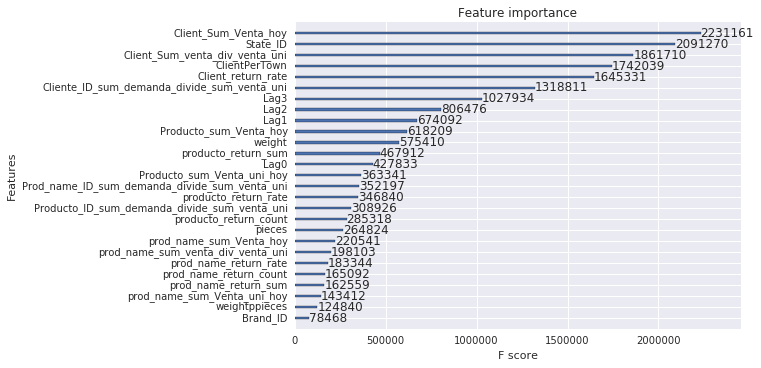

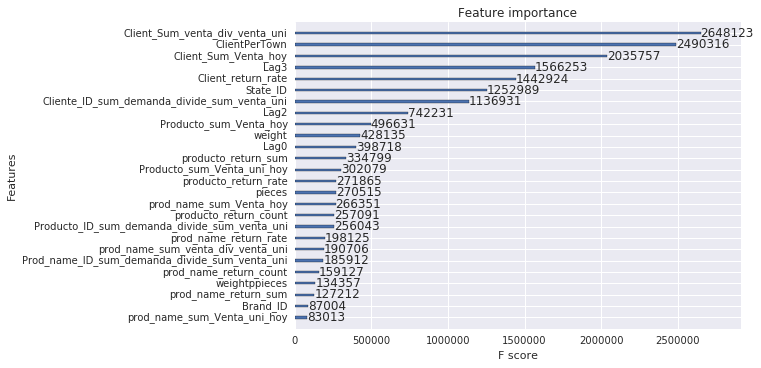

In [19]:
parameterDict =       {"ValidationStart":10, 
 "ValidationEnd":11,
   "maxLag":3,
    "trainHdfPath":'../../input/train_full_wz2.h5',
    "trainHdfFile":"train",
    "testHdfPath1":"../../input/test1_full_wz2.h5",
    "testHdfPath2":"../../input/test2_full_wz2.h5",
    "testHdfFile":"test", 
    "trainTypes" : {'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,'Ruta_SAK':np.uint16, 
        'Cliente_ID':np.uint32, 'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint16, 'Venta_hoy':np.float32,
                    'Dev_uni_proxima': np.uint32, 'Dev_proxima':np.float32,'Demanda_uni_equil':np.uint32}, 
    "testTypes" : {'id':np.uint32,'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,'Ruta_SAK':np.uint16,
        'Cliente_ID':np.uint32, 'Producto_ID':np.uint16},
    "trainCsvPath":'../../input/train.csv'   ,
    "testCsvPath":'../../input/test.csv'}

FE = FeatureEngineering(**parameterDict)
print FE.__dict__

gc.collect()

FE.ReadHdf('both')

gc.collect()
FE.DeleteLaggedWeeksFromTrain()
gc.collect()

FE.train[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Demanda_uni_equil_original',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate'
         ]]=FE.train[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Demanda_uni_equil_original',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate']].astype('float32')
gc.collect()
FE.train[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count'
         ]]=FE.train[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count']].astype('uint32')

gc.collect()

FE.test1[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate'
         ]]=FE.test1[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate']].astype('float32')
gc.collect()
FE.test1[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count'
         ]]=FE.test1[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count']].astype('uint32')

gc.collect()

FE.test2[['Lag0', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate'
         ]]=FE.test2[['Lag0', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate']].astype('float32')
gc.collect()
FE.test2[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count'
         ]]=FE.test2[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count']].astype('uint32')

gc.collect()

test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

X_train = FE.train[test1columns]
X_test = FE.test1[test1columns]
y_train = FE.train["Demanda_uni_equil"]
#y_test = FE.test1["Demanda_uni_equil"]

gc.collect()

print X_train.shape
print X_test.shape
print y_train.shape
#print y_test.shape

## Predict test1

clf1 = pickle.load(open("../../input/LastShot.pkl", "rb"))
clf1.set_params(**{"n_estimators" : clf1.best_iteration+1})
clf1.set_params(**{"max_depth" : 22})

clf1.fit(X_train,y_train, verbose=5, eval_set=[(X_train, y_train)])

predictions = clf1.predict(X_train,ntree_limit  = clf1.best_iteration+1)
predictionsTest = clf1.predict(X_test,ntree_limit  = clf1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
#print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", clf1.best_iteration
print "Best Score: ", clf1.best_score
print xgb.plot_importance(clf1)

submission1 = pd.DataFrame({'id':FE.test1.id, 'Demanda_uni_equil': predictionsTest})

gc.collect()


## Predict test2

X_train = FE.train[test2columns]
X_test = FE.test2[test2columns]
y_train = FE.train["Demanda_uni_equil"]
#y_test = FE.test2["Demanda_uni_equil"]

clf2 = pickle.load(open("../../input/LastShot2.pkl", "rb"))

clf2.set_params(**{"n_estimators" : clf2.best_iteration+1})
clf2.set_params(**{"max_depth" : 22})
clf2.fit(X_train,y_train, verbose=5, eval_set=[(X_train, y_train)])

predictions = clf2.predict(X_train,ntree_limit  = clf2.best_iteration+1)
predictionsTest = clf2.predict(X_test,ntree_limit  = clf2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
#print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", clf2.best_iteration
print "Best Score: ", clf2.best_score
print xgb.plot_importance(clf2)

submission2 = pd.DataFrame({'id':FE.test2.id, 'Demanda_uni_equil': predictionsTest})

gc.collect()

## Arrange Submission File

submission = submission2.append(submission1)

submission.loc[:,"Demanda_uni_equil"] = np.round(np.expm1(submission["Demanda_uni_equil"]))

submission.sort_values(by="id",inplace=True)

print (submission.id == 0).sum()

In [20]:
print submission.head(20)

print submission.shape

    Demanda_uni_equil  id
0                 4.0   0
1                 1.0   1
0                 2.0   2
2                 2.0   3
3                 3.0   4
4                 3.0   5
5                 1.0   6
1                 5.0   7
2                 4.0   8
6                 4.0   9
7                 7.0  10
3                 2.0  11
8                 5.0  12
4                 5.0  13
5                 2.0  14
9                 4.0  15
10                2.0  16
11                2.0  17
6                 1.0  18
12                3.0  19
(6999251, 2)


In [21]:
from datetime import datetime

submission[["id","Demanda_uni_equil"]].to_csv('../../input/' + 
                                              datetime.now().strftime('%Y-%m-%d-%H-%M-%S') +'.csv', index=False)